In [3]:
import pandas as pd
import zipfile
import os

# Define the path to the zip file and the directory to extract its contents
zip_file_path = 'C:\\Users\\anshi\\OneDrive\\Desktop\\Intel New\\adult.zip'
extract_dir = 'C:\\Users\\anshi\\OneDrive\\Desktop\\Intel New'

# Create the extraction directory if it does not exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Define the path to the adult.data file
data_file_path = os.path.join(extract_dir, 'adult.data')

# Load the data into a pandas DataFrame
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

adult_data = pd.read_csv(data_file_path, header=None, names=column_names, na_values=' ?', skipinitialspace=True)

# Replace '?' with NaN and drop rows with missing values
adult_data_cleaned = adult_data.dropna()

# Convert categorical variables to category data type
for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']:
    adult_data_cleaned[col] = adult_data_cleaned[col].astype('category')


In [4]:
from sklearn.preprocessing import StandardScaler

# Encode categorical variables using one-hot encoding
adult_data_encoded = pd.get_dummies(adult_data_cleaned, drop_first=True)

# Identify numerical features
numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Normalize numerical features
scaler = StandardScaler()
adult_data_encoded[numerical_columns] = scaler.fit_transform(adult_data_encoded[numerical_columns])


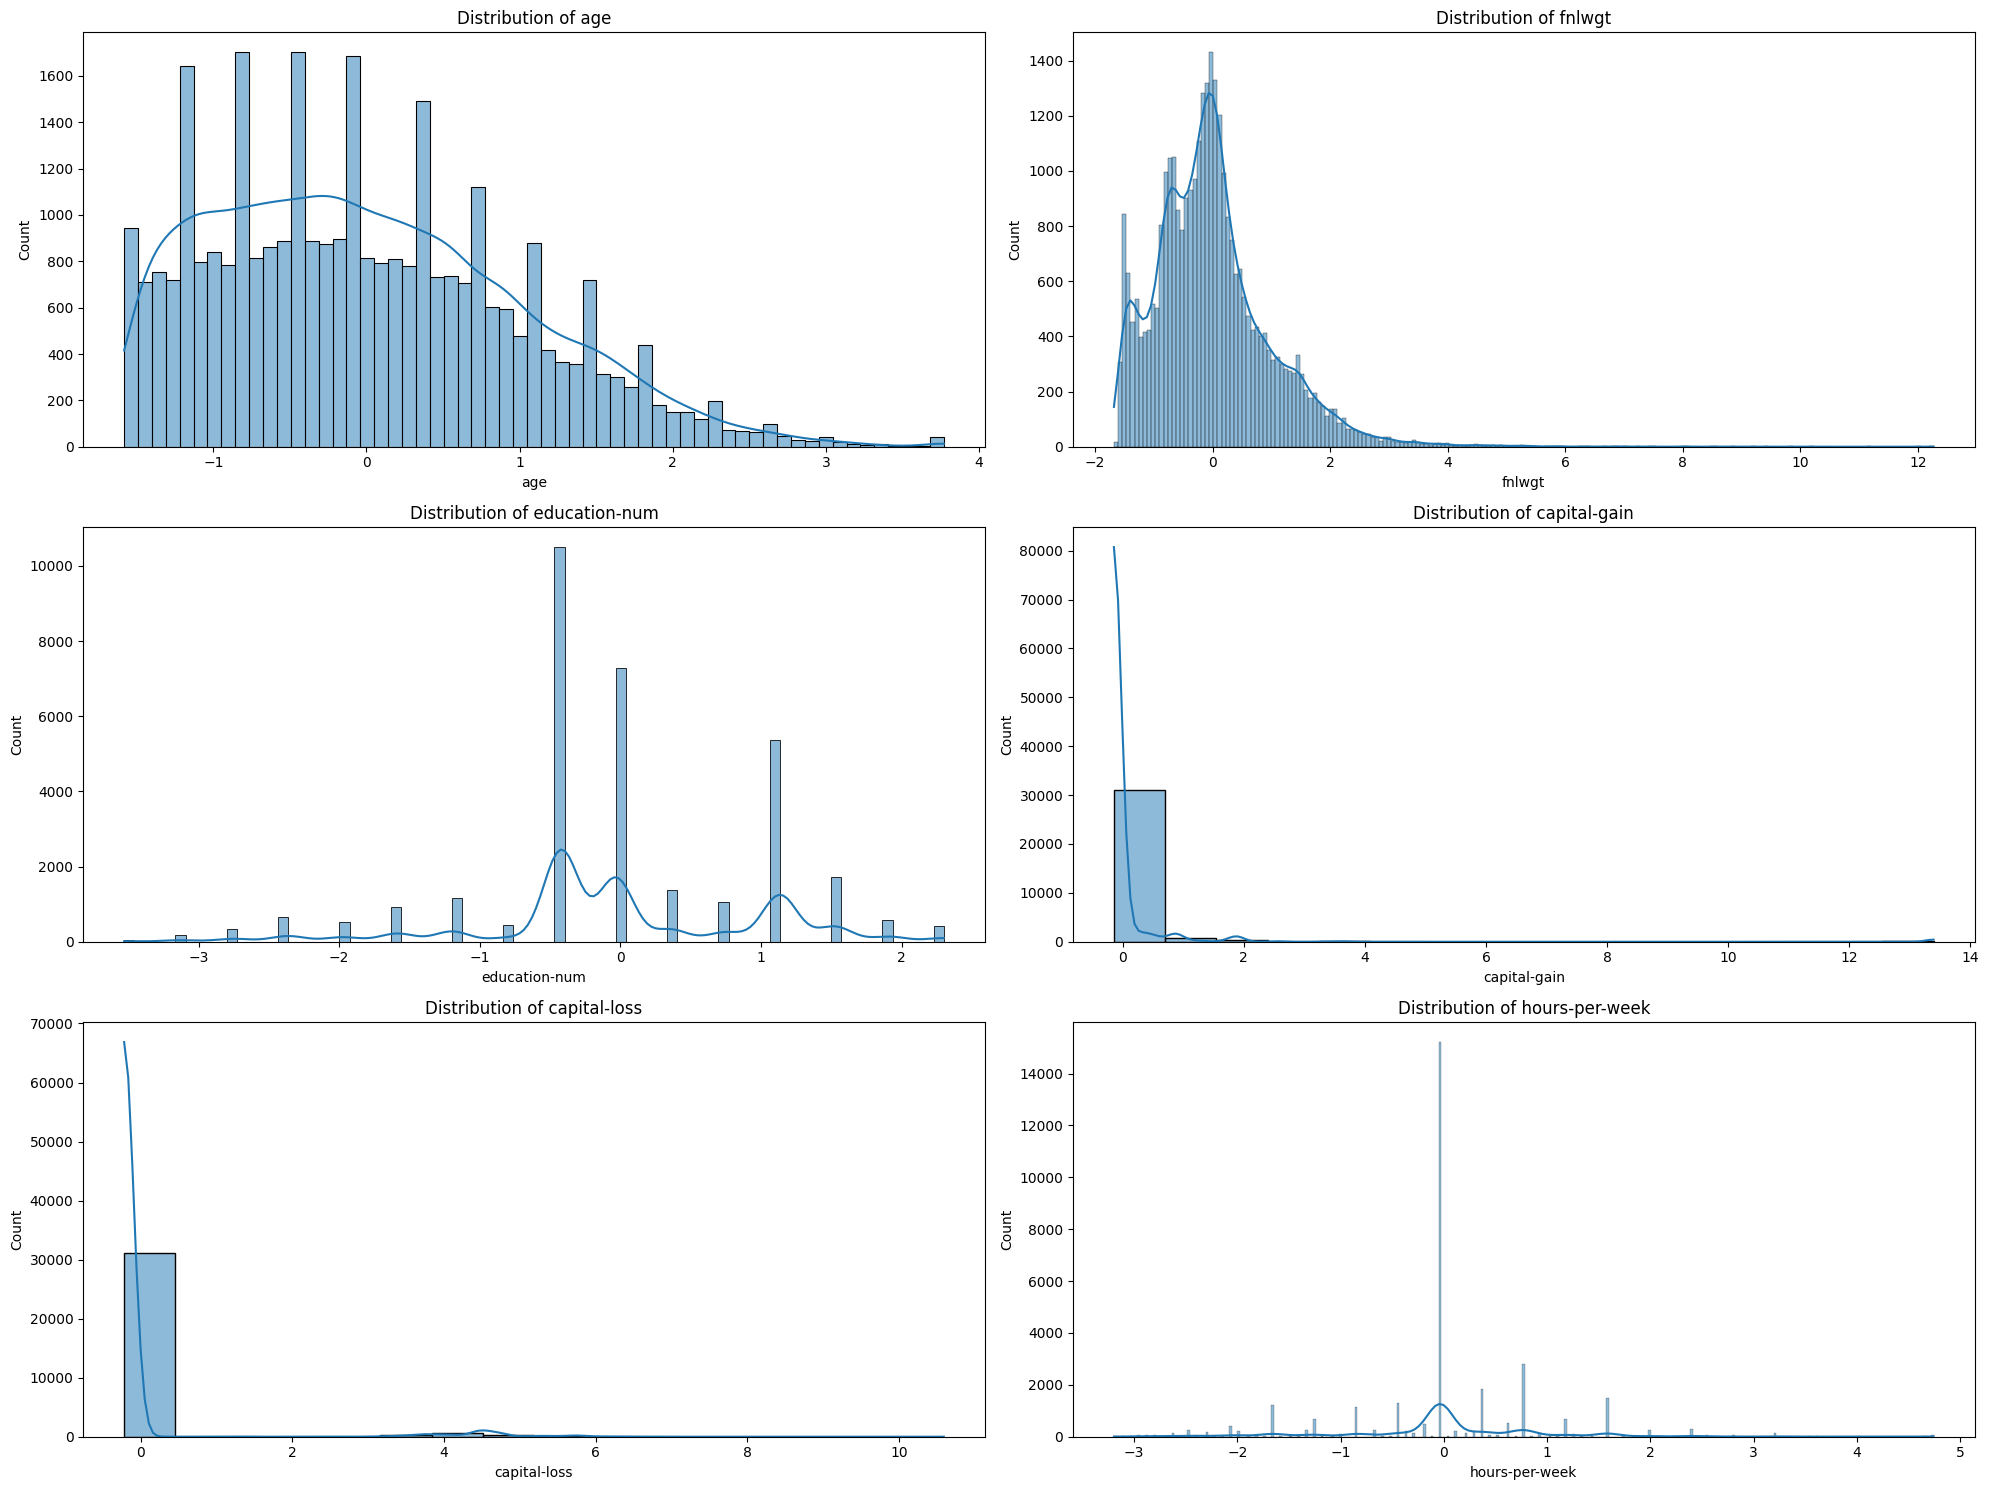

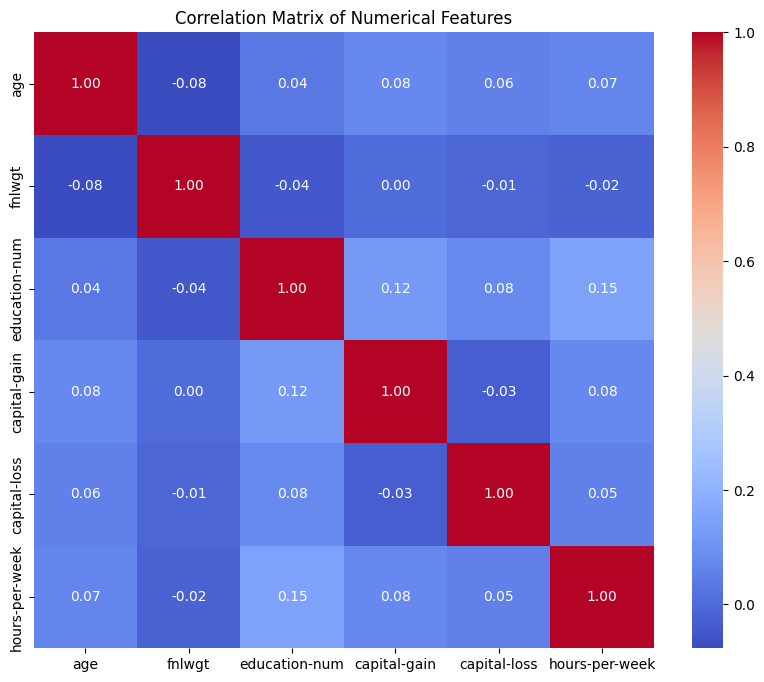

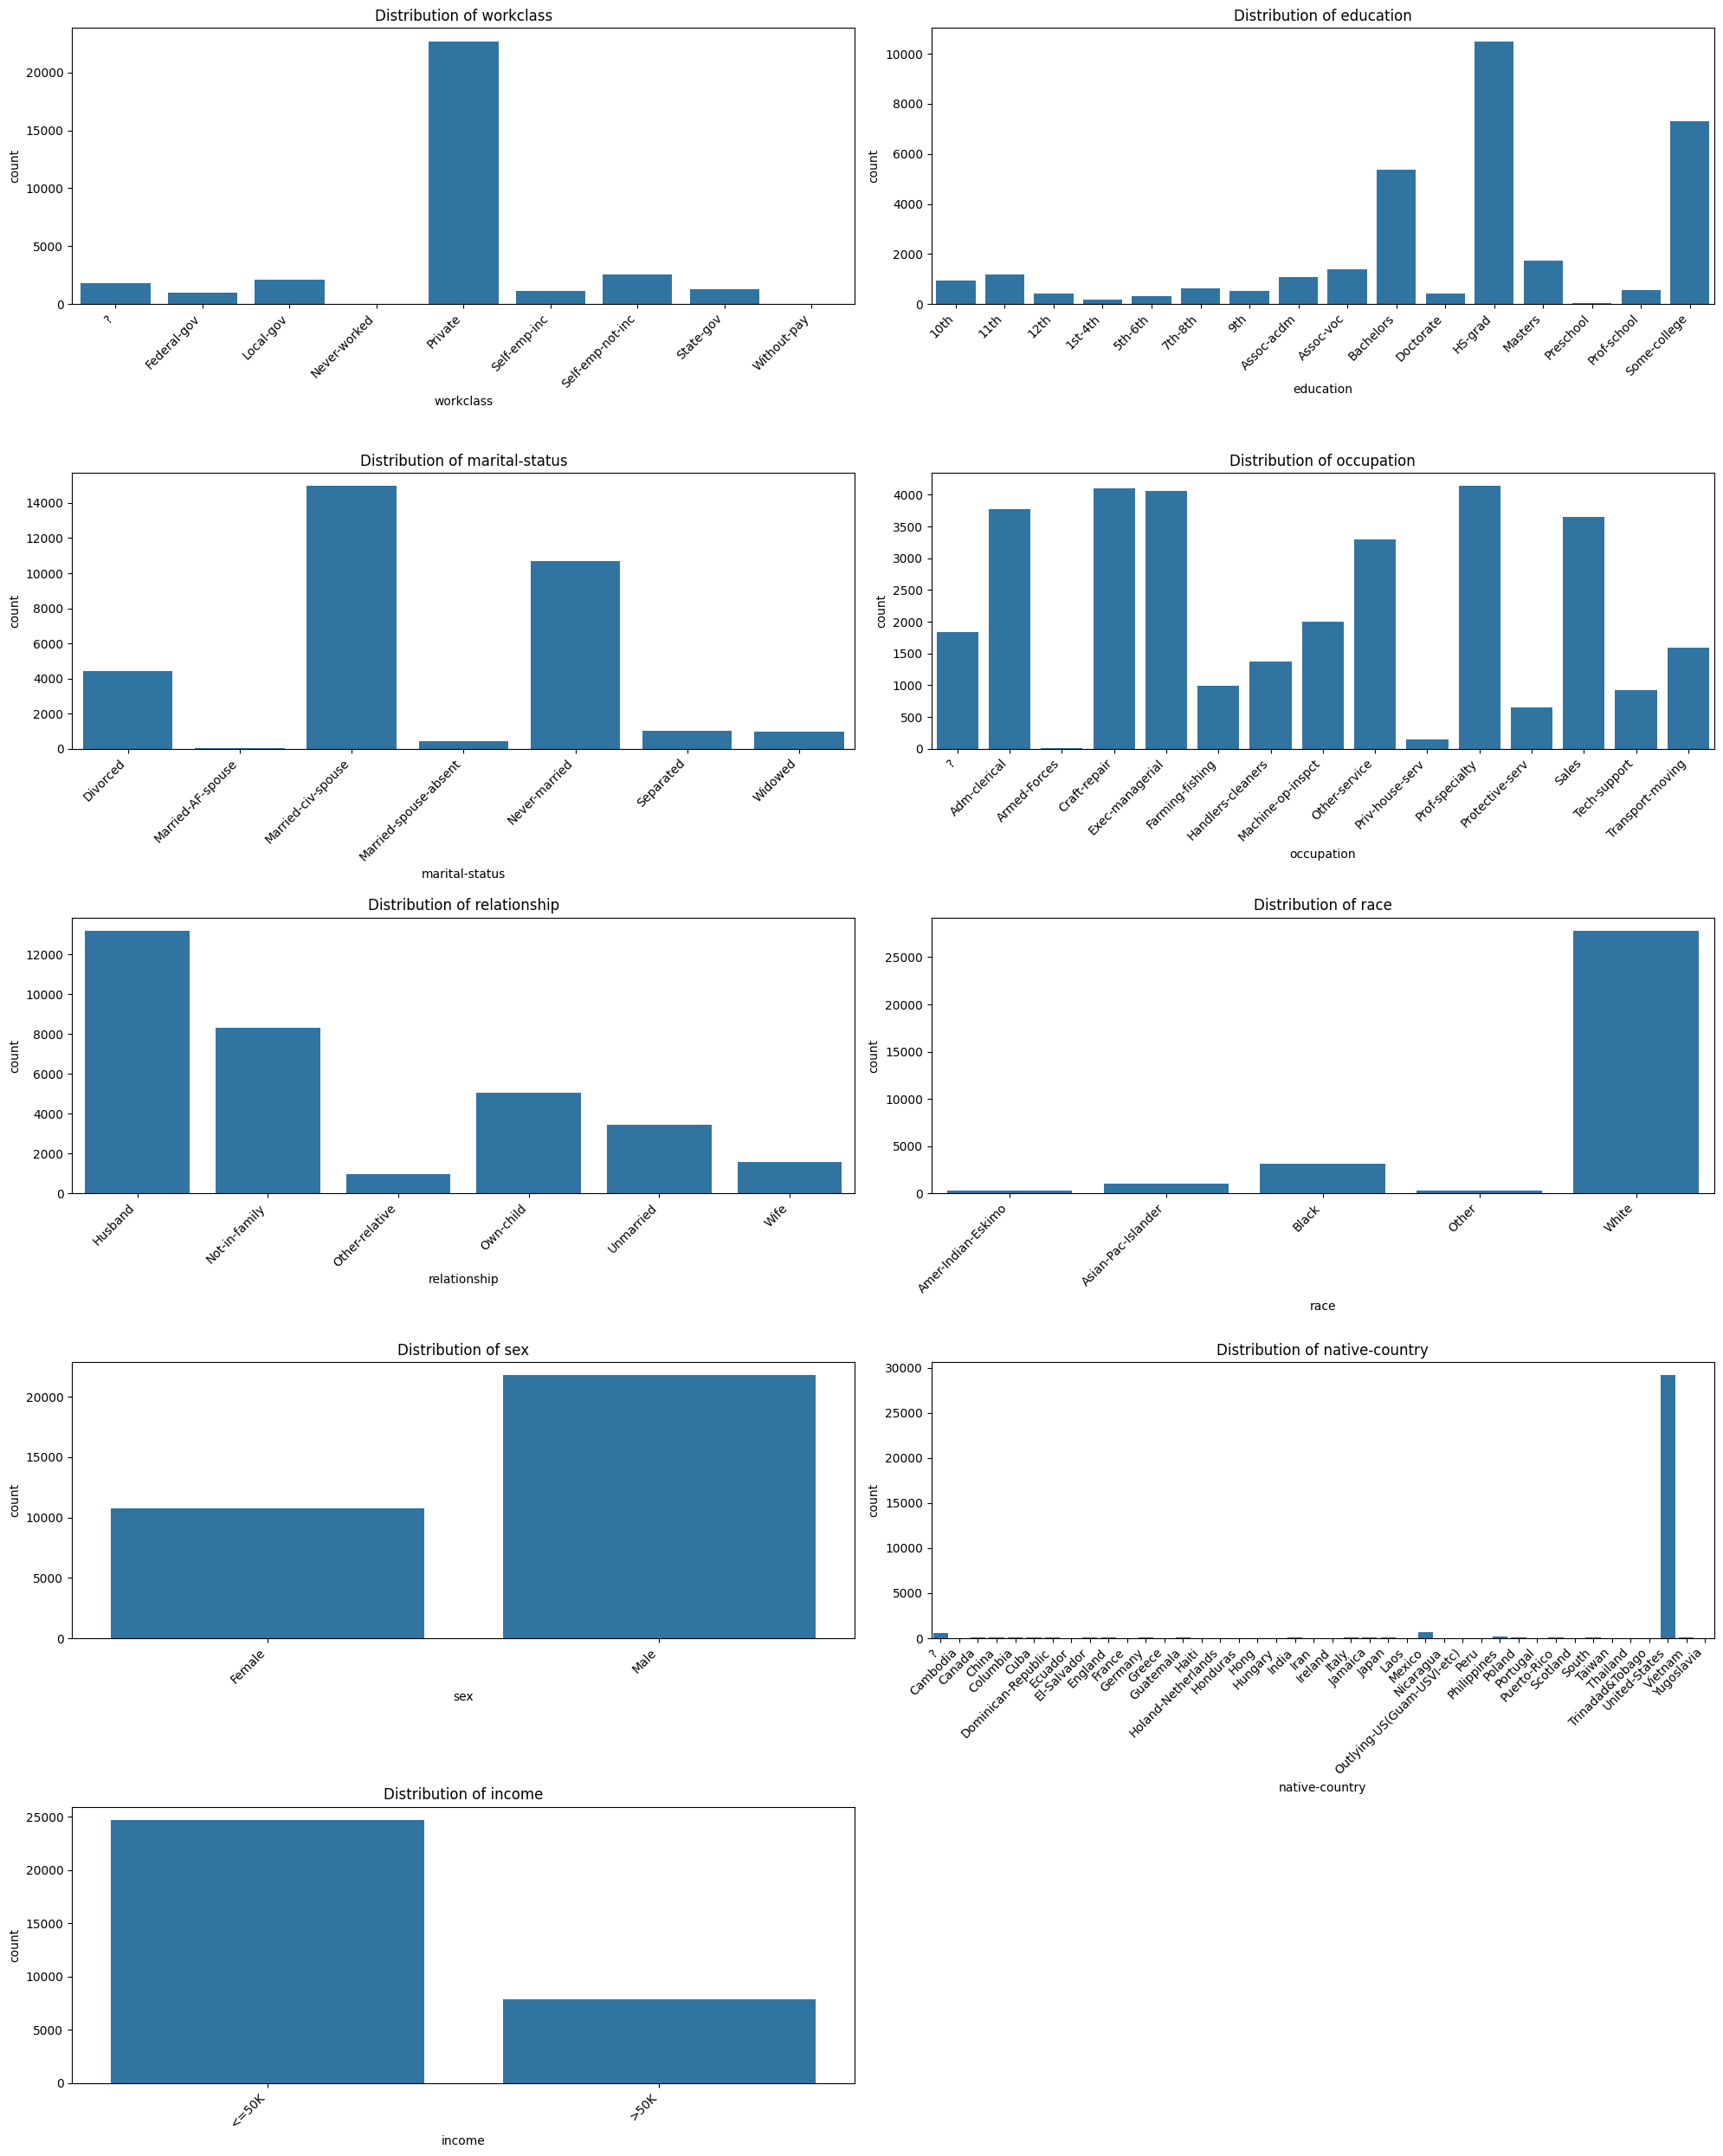

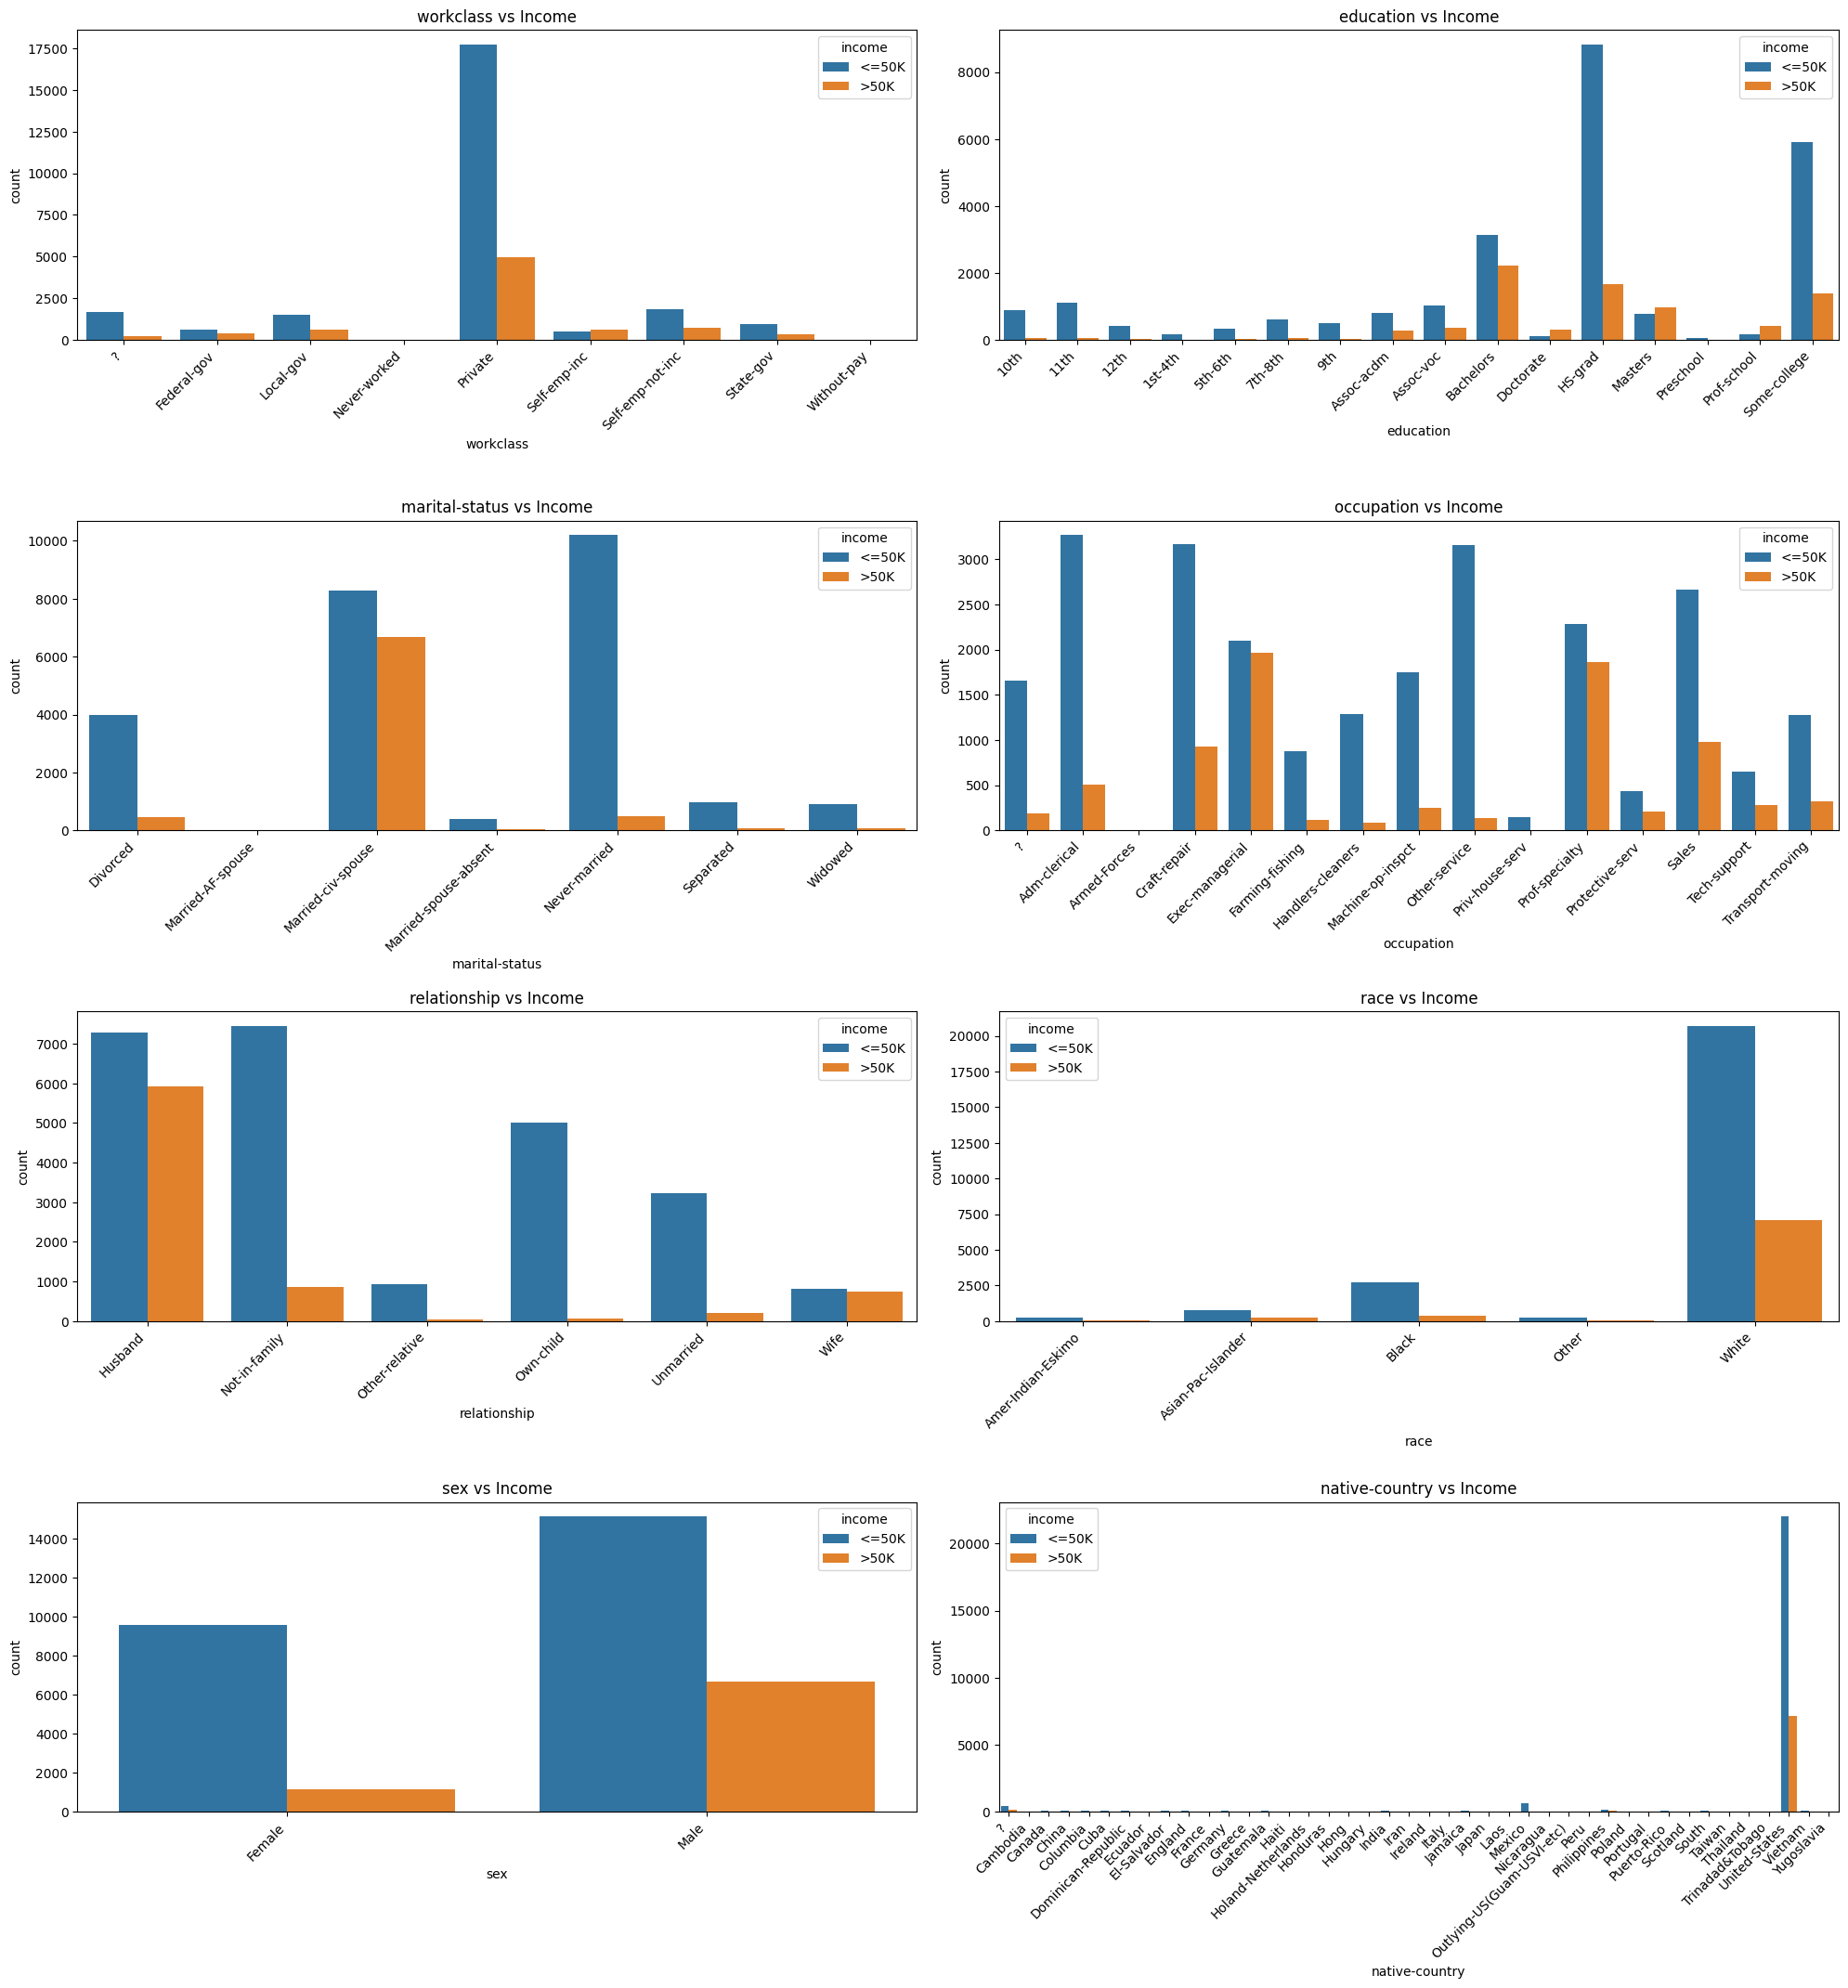

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure for numerical feature distributions
plt.figure(figsize=(20, 15))

# Plot histograms for each numerical feature
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(adult_data_encoded[col], kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

# Calculate the correlation matrix
correlation_matrix = adult_data_encoded[numerical_columns].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Set up the matplotlib figure for categorical feature distributions
plt.figure(figsize=(20, 25))

# Plot count plots for each categorical feature
for i, col in enumerate(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income'], 1):
    plt.subplot(5, 2, i)
    sns.countplot(data=adult_data_cleaned, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Set up the matplotlib figure for relationships between categorical features and income
plt.figure(figsize=(20, 25))

# Plot count plots for each categorical feature colored by income
for i, col in enumerate(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'], 1):  # Exclude 'income' itself
    plt.subplot(5, 2, i)
    sns.countplot(data=adult_data_cleaned, x=col, hue='income')
    plt.title(f'{col} vs Income')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [17]:
def detect_outliers(df, numerical_columns):
    outliers = {}
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return outliers

# Assuming 'adult_data_cleaned' is your DataFrame and 'numerical_columns' contains the list of numerical column names
numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Detect outliers in numerical columns
outliers = detect_outliers(adult_data_cleaned, numerical_columns)

# Display the outliers for each numerical column
for col, outlier_series in outliers.items():
    print(f"Outliers detected in {col}:")
    print(outlier_series)
    print("\n")


Outliers detected in age:
74       79
222      90
430      80
918      81
1040     90
         ..
32277    90
32367    90
32459    85
32494    82
32525    81
Name: age, Length: 143, dtype: int64


Outliers detected in fnlwgt:
37       544091
40       507875
80       446839
110      432376
157      494223
          ...  
32306    427686
32329    435842
32470    485710
32496    436163
32511    514716
Name: fnlwgt, Length: 992, dtype: int64


Outliers detected in education-num:
15       4
56       3
61       4
79       4
160      2
        ..
32431    4
32432    1
32448    4
32479    4
32517    4
Name: education-num, Length: 1198, dtype: int64


Outliers detected in capital-gain:
0         2174
8        14084
9         5178
59        5013
60        2407
         ...  
32515     3471
32518    99999
32538    15020
32548     1086
32560    15024
Name: capital-gain, Length: 2712, dtype: int64


Outliers detected in capital-loss:
23       2042
32       1408
52       1902
93       1573
96       

In [7]:
# Create age groups
age_bins = [0, 20, 40, 60, 80, 100]
age_labels = ['0-20', '21-40', '41-60', '61-80', '81-100']
adult_data_cleaned['age_group'] = pd.cut(adult_data_cleaned['age'], bins=age_bins, labels=age_labels, right=False)

# Combine capital-gain and capital-loss into a single feature
adult_data_cleaned['capital_diff'] = adult_data_cleaned['capital-gain'] - adult_data_cleaned['capital-loss']

# Create working hours category
hours_bins = [0, 20, 40, 60, 100]
hours_labels = ['Part-time', 'Full-time', 'Over-time', 'Extreme']
adult_data_cleaned['working_hours_category'] = pd.cut(adult_data_cleaned['hours-per-week'], bins=hours_bins, labels=hours_labels, right=False)

# Ensure 'hours-per-week' is converted to numerical type for division
adult_data_cleaned['hours-per-week'] = adult_data_cleaned['hours-per-week'].astype(float)

# Recalculate the approximate income per hour
income_map = {'<=50K': 25000, '>50K': 75000}
adult_data_cleaned['approx_income'] = adult_data_cleaned['income'].map(income_map).astype(float)
adult_data_cleaned['income_per_hour'] = adult_data_cleaned['approx_income'] / adult_data_cleaned['hours-per-week']

# Drop the temporary approximate income column
adult_data_cleaned.drop('approx_income', axis=1, inplace=True)


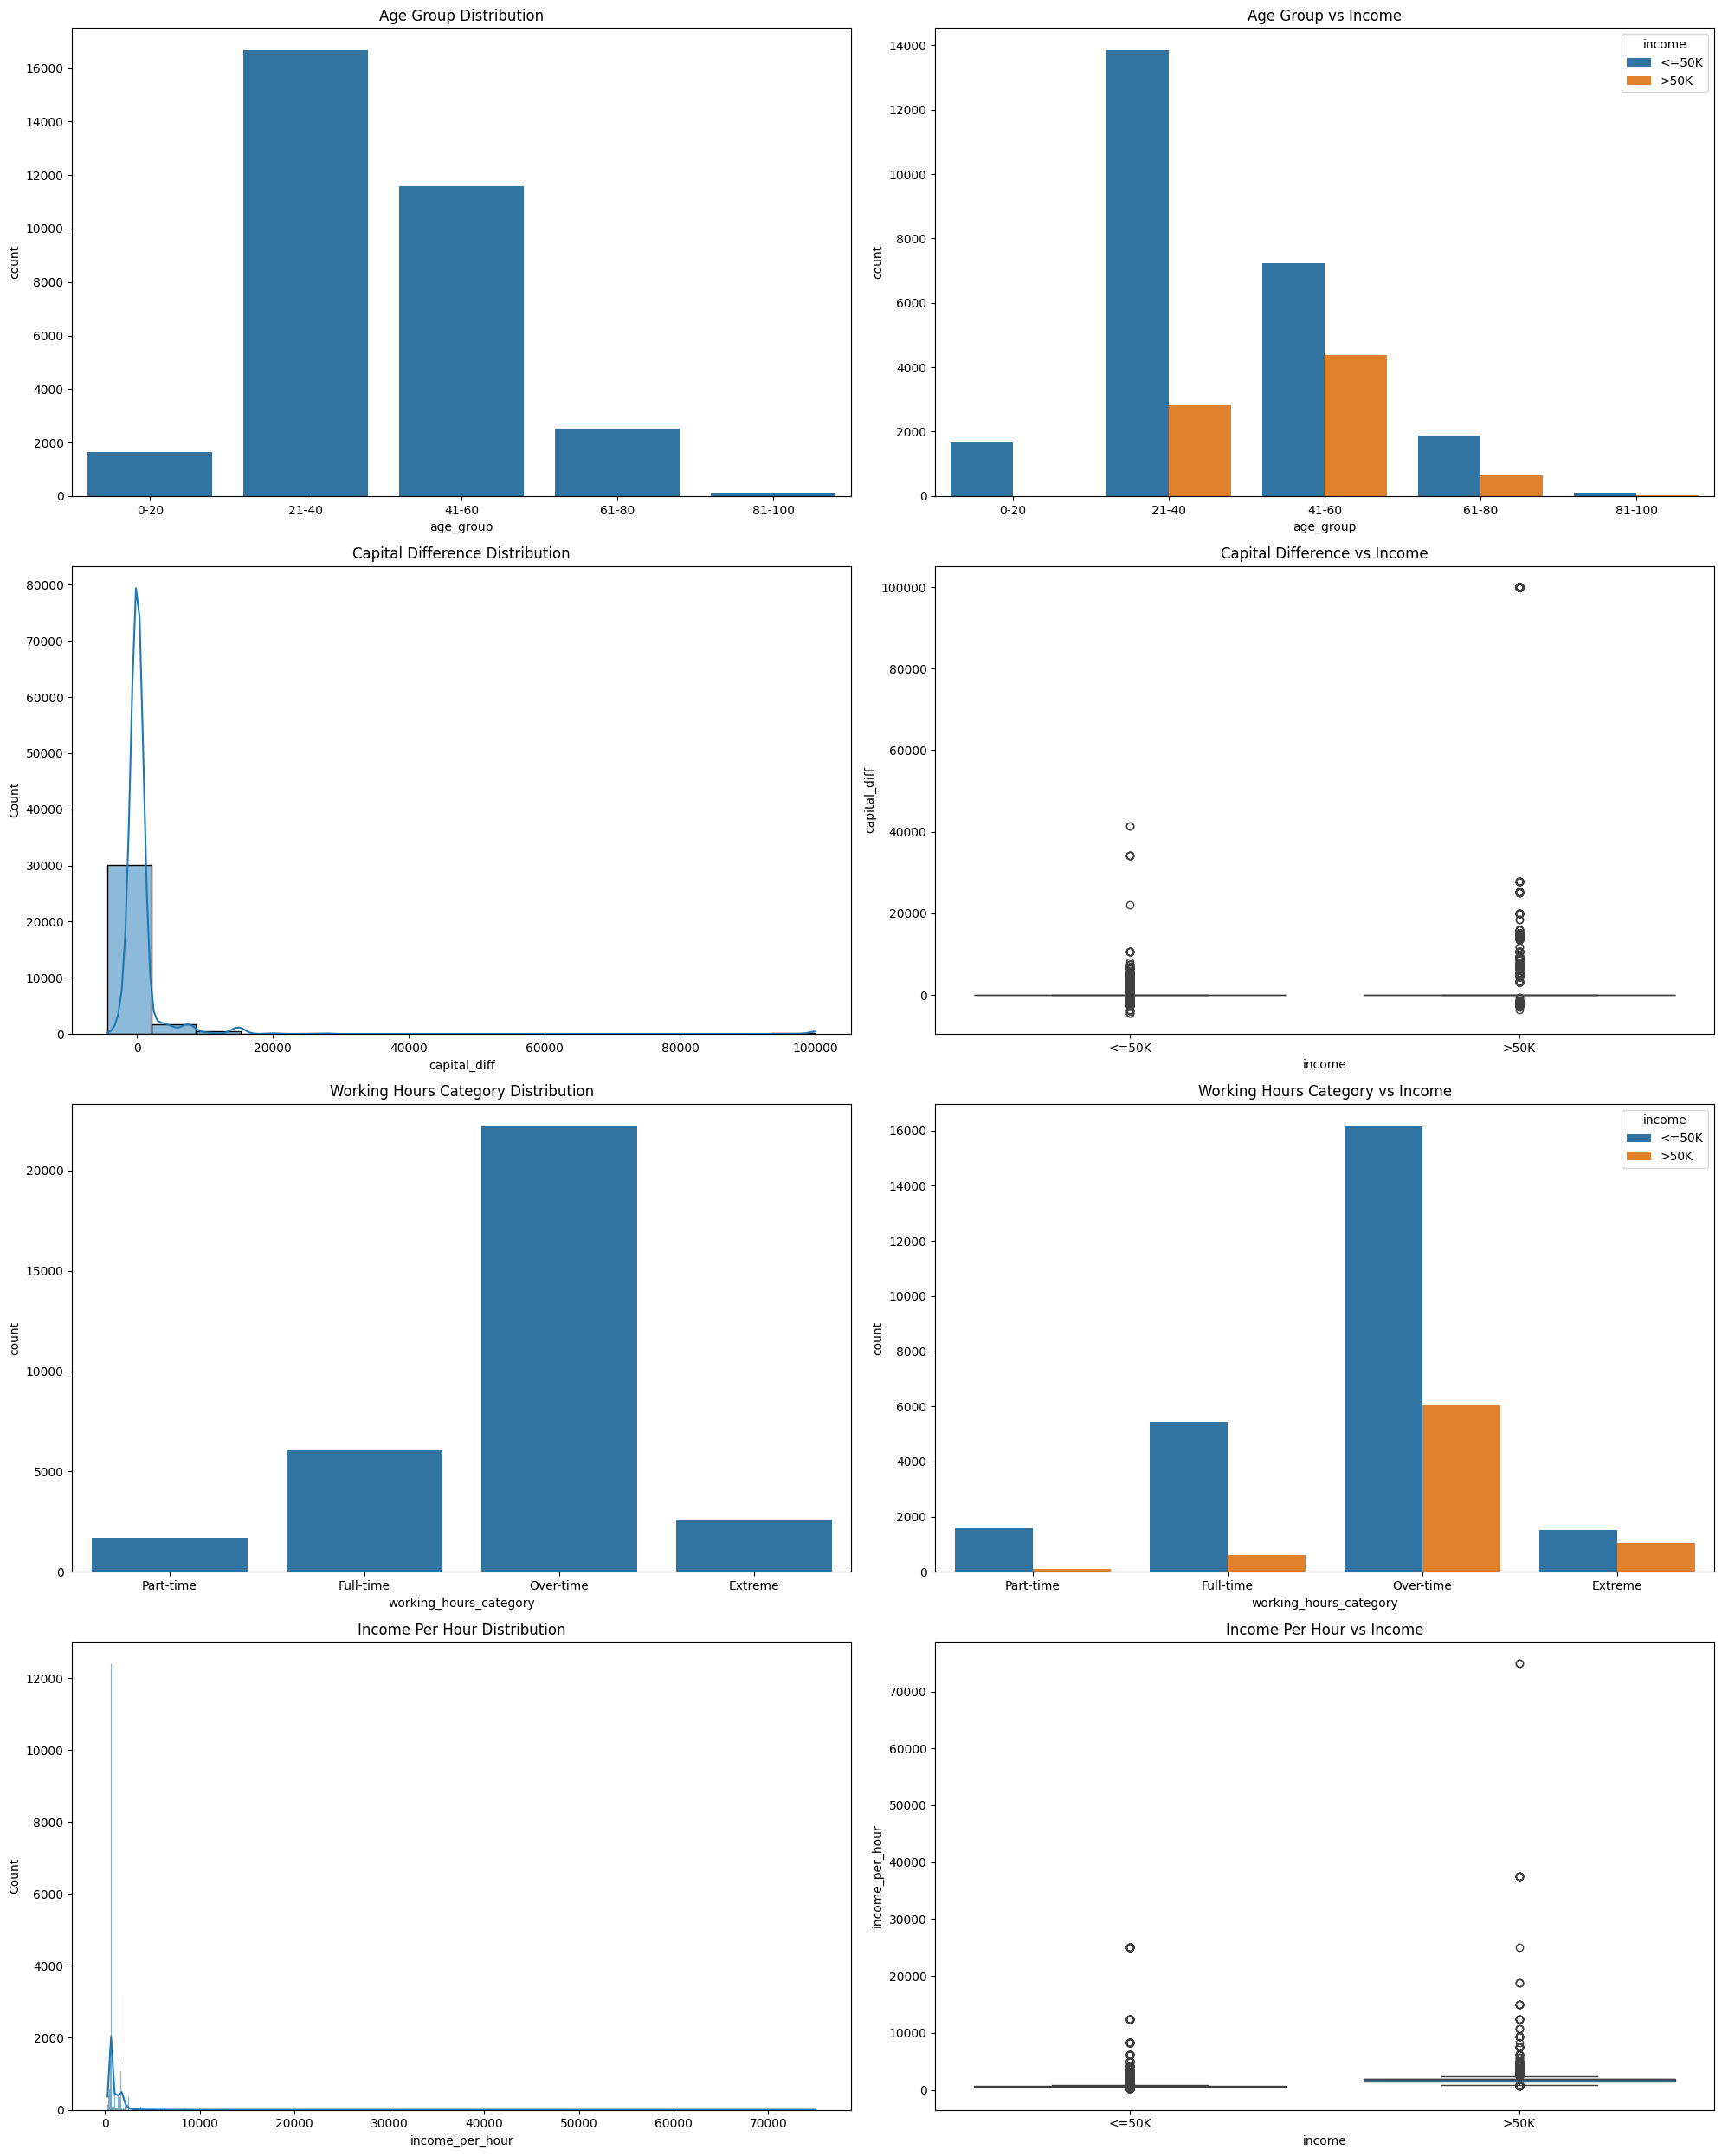

In [8]:
# Set up the matplotlib figure for the new features' EDA
plt.figure(figsize=(20, 25))

# Plot count plot for age group distribution
plt.subplot(4, 2, 1)
sns.countplot(data=adult_data_cleaned, x='age_group')
plt.title('Age Group Distribution')

# Plot count plot for age group vs income
plt.subplot(4, 2, 2)
sns.countplot(data=adult_data_cleaned, x='age_group', hue='income')
plt.title('Age Group vs Income')

# Plot histogram for capital difference distribution
plt.subplot(4, 2, 3)
sns.histplot(adult_data_cleaned['capital_diff'], kde=True)
plt.title('Capital Difference Distribution')

# Plot boxplot for capital difference vs income
plt.subplot(4, 2, 4)
sns.boxplot(data=adult_data_cleaned, x='income', y='capital_diff')
plt.title('Capital Difference vs Income')

# Plot count plot for working hours category distribution
plt.subplot(4, 2, 5)
sns.countplot(data=adult_data_cleaned, x='working_hours_category')
plt.title('Working Hours Category Distribution')

# Plot count plot for working hours category vs income
plt.subplot(4, 2, 6)
sns.countplot(data=adult_data_cleaned, x='working_hours_category', hue='income')
plt.title('Working Hours Category vs Income')

# Plot histogram for income per hour distribution
plt.subplot(4, 2, 7)
sns.histplot(adult_data_cleaned['income_per_hour'], kde=True)
plt.title('Income Per Hour Distribution')

# Plot boxplot for income per hour vs income
plt.subplot(4, 2, 8)
sns.boxplot(data=adult_data_cleaned, x='income', y='income_per_hour')
plt.title('Income Per Hour vs Income')

plt.tight_layout()
plt.show()


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Prepare the data: Encode categorical features and split into train/test sets
adult_data_prepared = pd.get_dummies(adult_data_cleaned, drop_first=True)
X = adult_data_prepared.drop('income_>50K', axis=1)
y = adult_data_prepared['income_>50K']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Create a DataFrame to hold feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
})

# Sort the DataFrame by importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Display the top 20 most important features
top_20_features = feature_importance_df.head(20)
top_20_features


,feature,importance
7,income_per_hour,0.519785
5,hours-per-week,0.062773
32,marital-status_Married-civ-spouse,0.054215
6,capital_diff,0.043922
0,age,0.032699
3,capital-gain,0.032341
2,education-num,0.031805
34,marital-status_Never-married,0.028210
107,working_hours_category_Over-time,0.020529
1,fnlwgt,0.015875


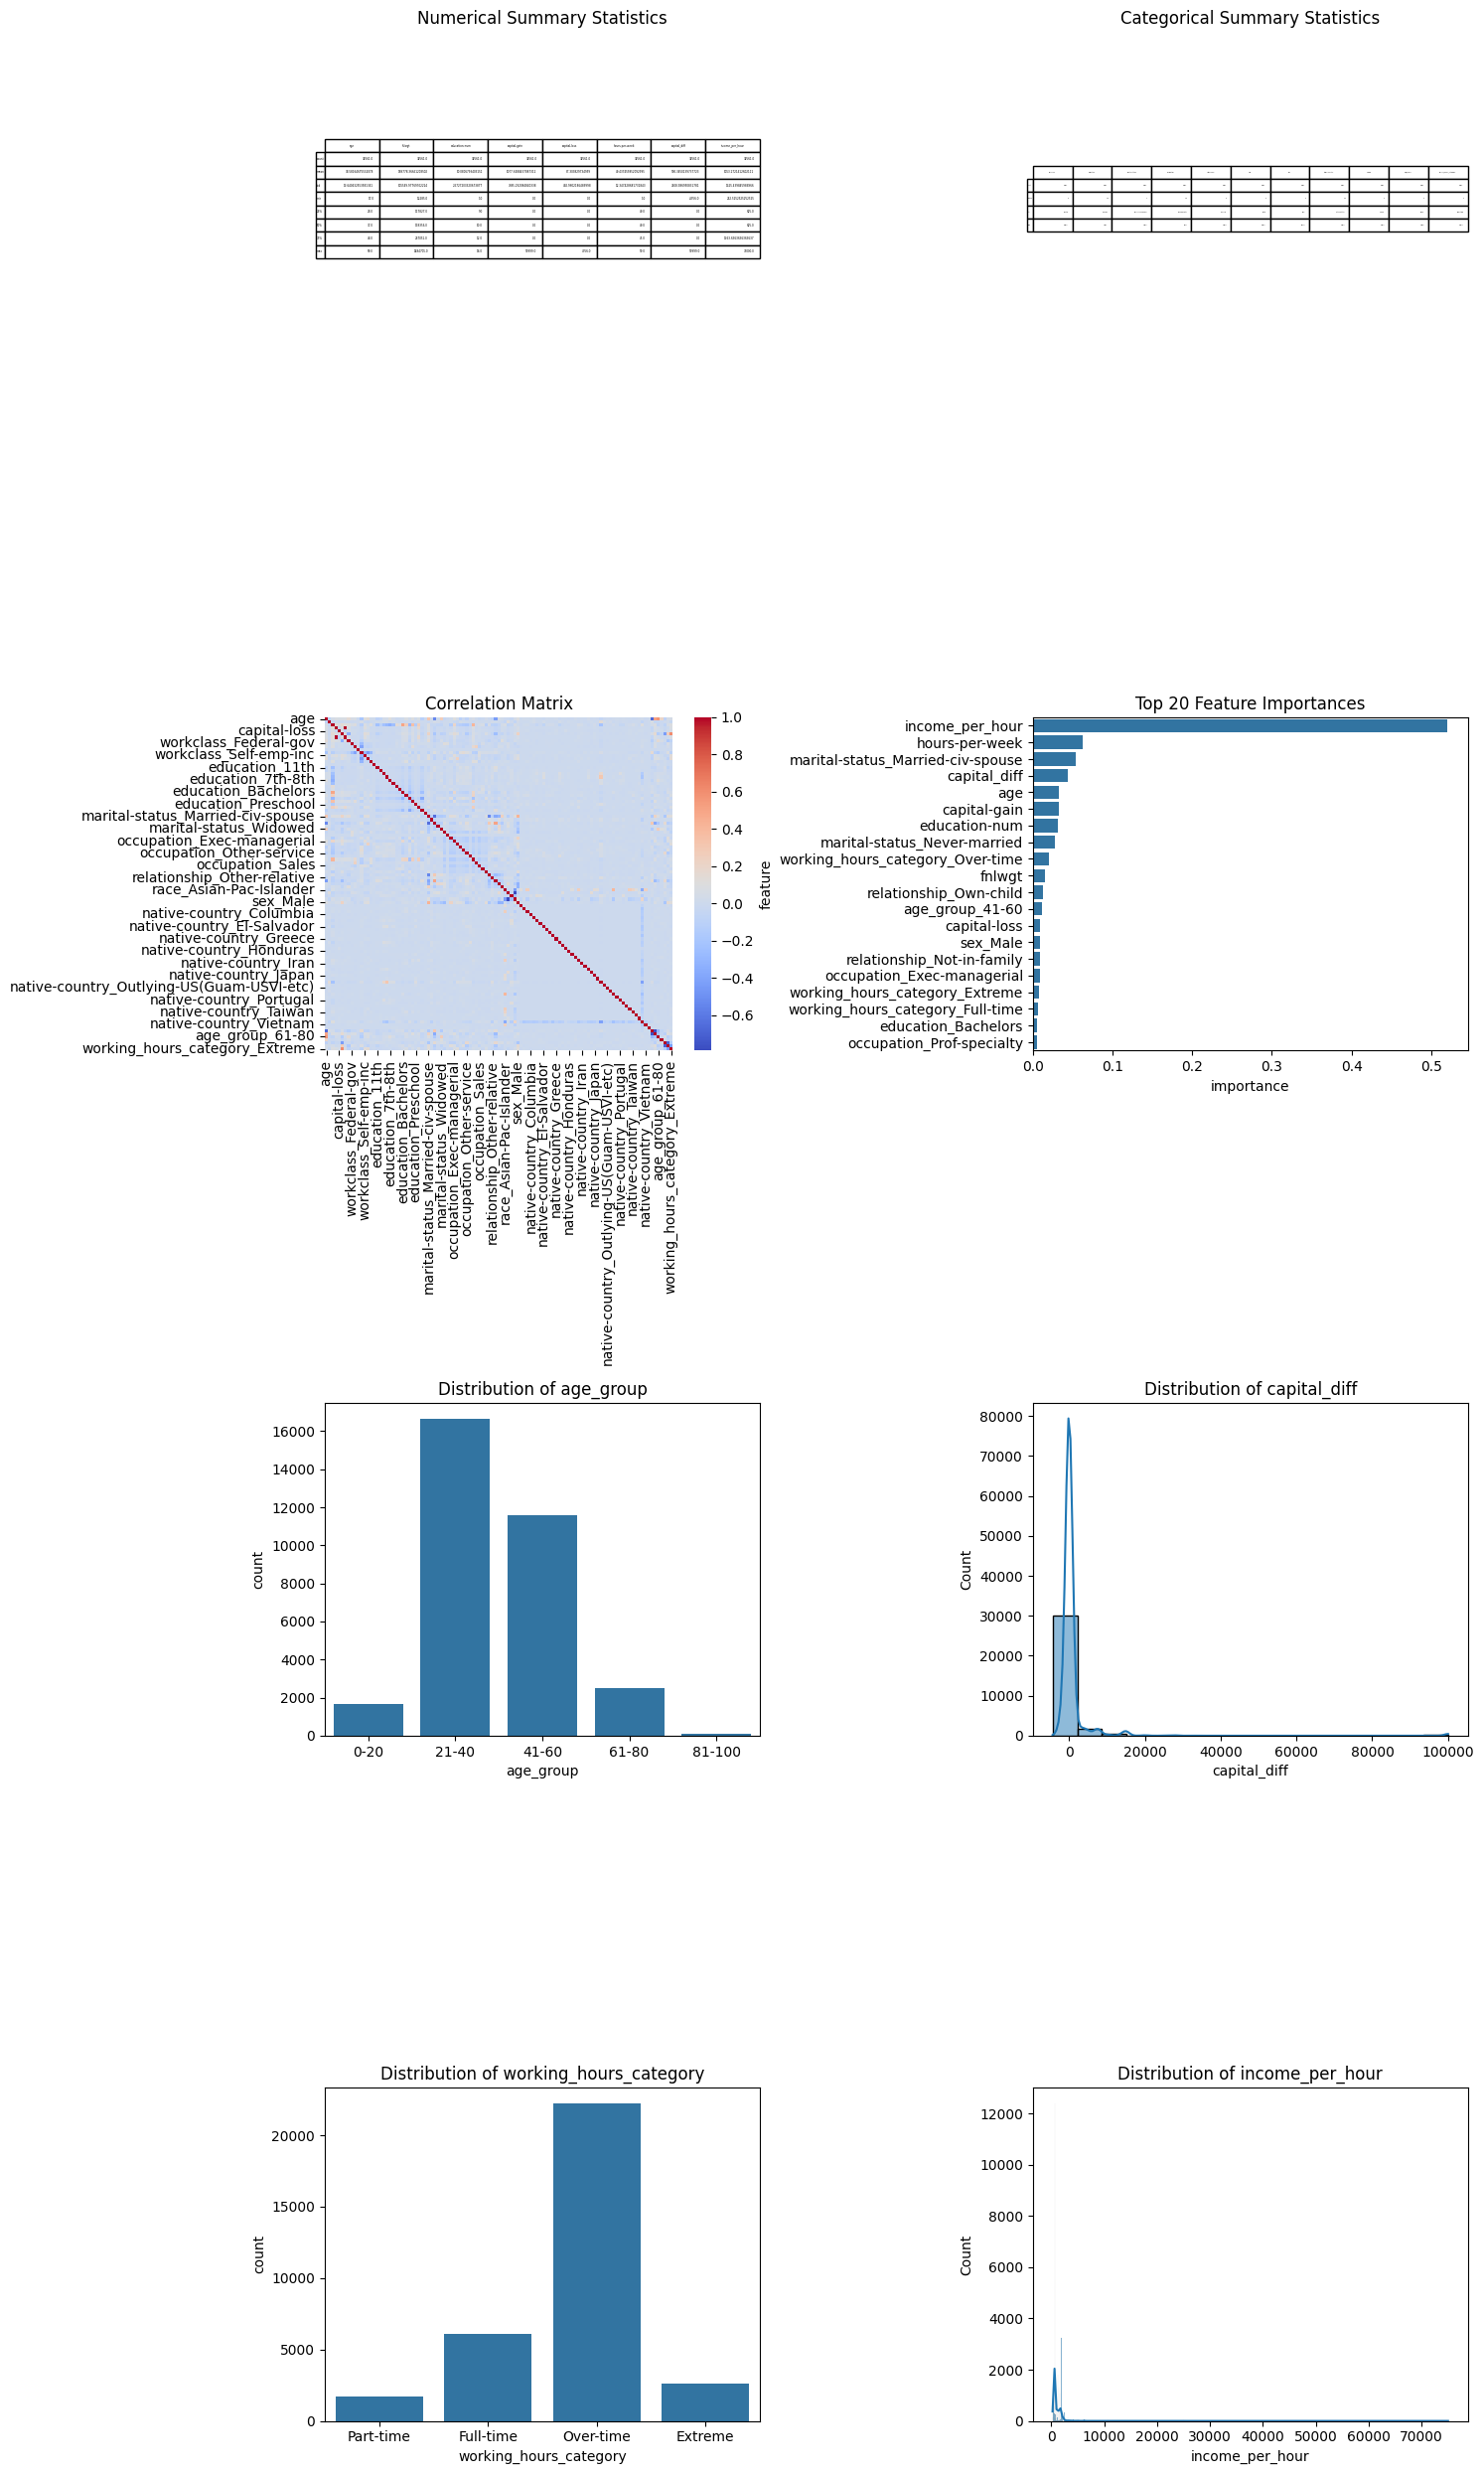

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming adult_data_cleaned and other necessary data have been defined and preprocessed as shown earlier

# Create a report with the insights and graphs

# Summary statistics for numerical features
numerical_summary = adult_data_cleaned.describe()

# Summary statistics for categorical features
categorical_columns = adult_data_cleaned.select_dtypes(include=['category']).columns
categorical_summary = adult_data_cleaned[categorical_columns].describe()

# Prepare the data: Encode categorical features and split into train/test sets
adult_data_prepared = pd.get_dummies(adult_data_cleaned, drop_first=True)
X = adult_data_prepared.drop('income_>50K', axis=1)
y = adult_data_prepared['income_>50K']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Get feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)
top_20_features = feature_importance_df.head(20)

# Create the report
plt.figure(figsize=(15, 25))

# Plot numerical summary statistics
plt.subplot(4, 2, 1)
plt.title('Numerical Summary Statistics')
plt.table(cellText=numerical_summary.values,
          rowLabels=numerical_summary.index,
          colLabels=numerical_summary.columns,
          loc='center')
plt.axis('off')

# Plot categorical summary statistics
plt.subplot(4, 2, 2)
plt.title('Categorical Summary Statistics')
plt.table(cellText=categorical_summary.values,
          rowLabels=categorical_summary.index,
          colLabels=categorical_summary.columns,
          loc='center')
plt.axis('off')

# Plot the correlation matrix
plt.subplot(4, 2, 3)
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')

# Plot feature importances
plt.subplot(4, 2, 4)
sns.barplot(x='importance', y='feature', data=top_20_features)
plt.title('Top 20 Feature Importances')

# Plot distributions of new features
new_features = ['age_group', 'capital_diff', 'working_hours_category', 'income_per_hour']
for i, feature in enumerate(new_features, 1):
    plt.subplot(4, 2, 4+i)
    if feature == 'age_group' or feature == 'working_hours_category':
        sns.countplot(data=adult_data_cleaned, x=feature)
    else:
        sns.histplot(adult_data_cleaned[feature], kde=True)
    plt.title(f'Distribution of {feature}')

# Adjust layout
plt.tight_layout()
plt.savefig('report.png')
plt.show()


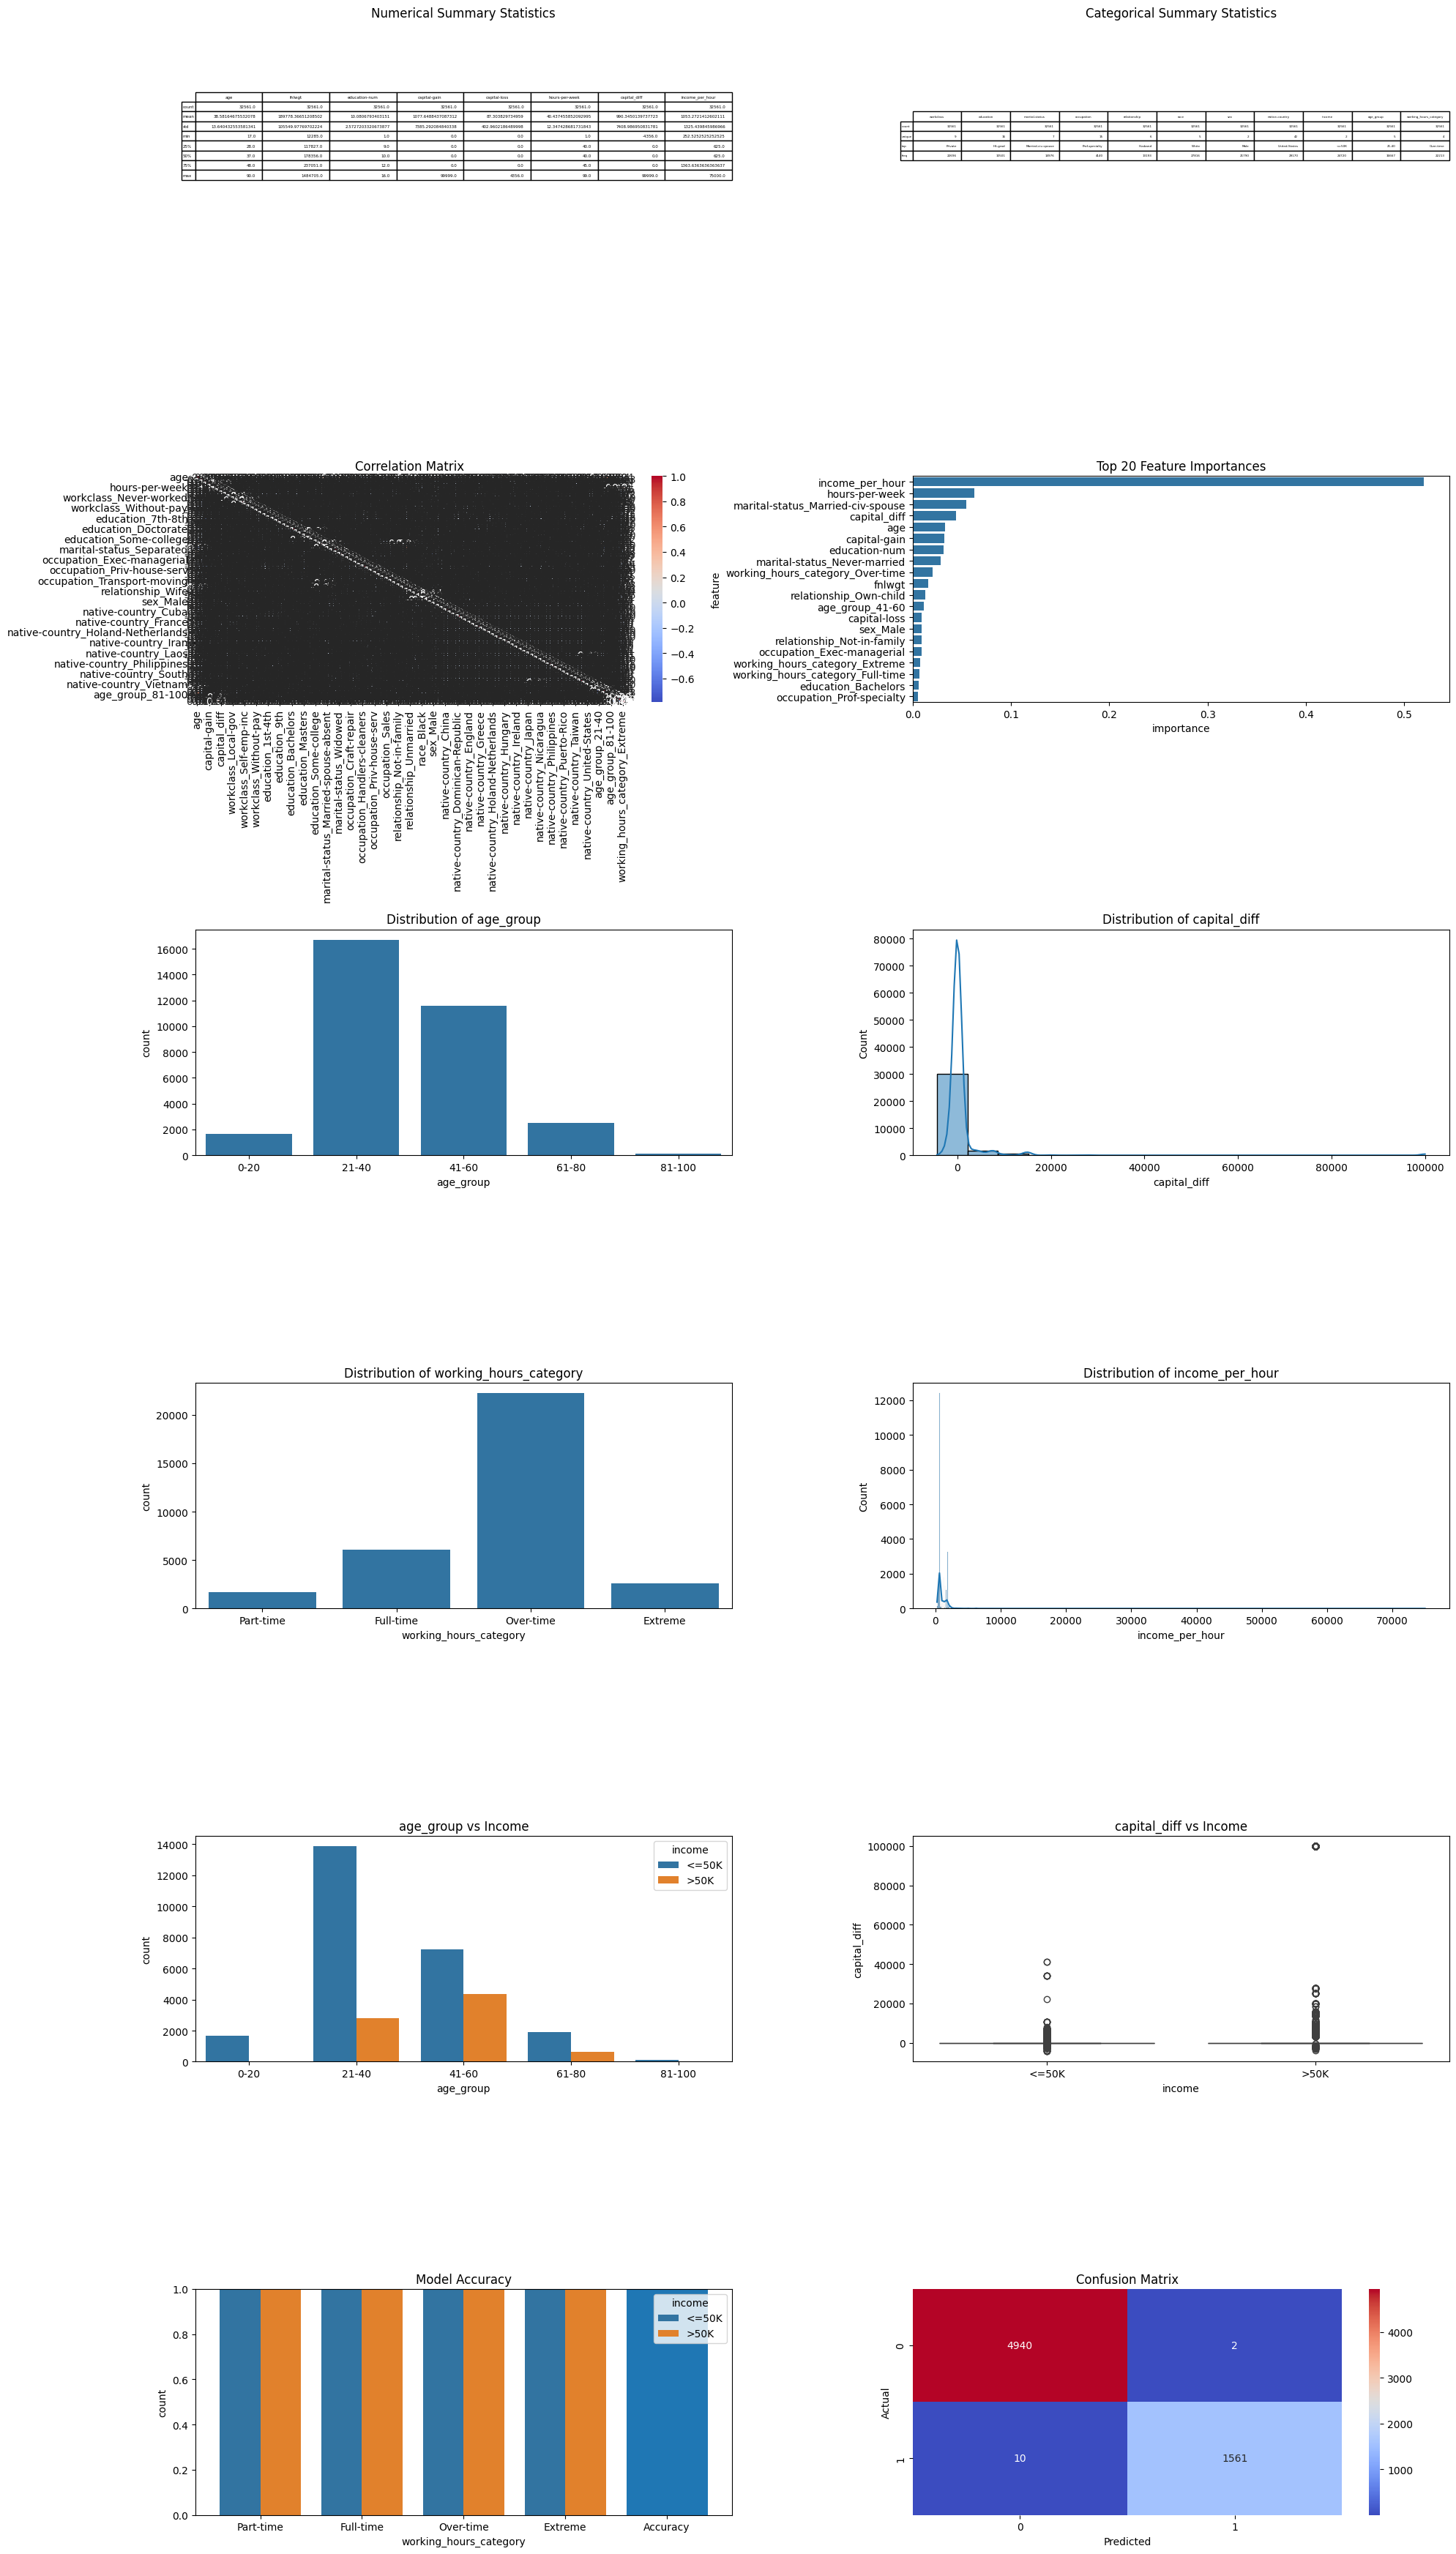

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      4942
        True       1.00      0.99      1.00      1571

    accuracy                           1.00      6513
   macro avg       1.00      1.00      1.00      6513
weighted avg       1.00      1.00      1.00      6513



In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming adult_data_cleaned and other necessary data have been defined and preprocessed as shown earlier

# Create a report with the insights and graphs

# Summary statistics for numerical features
numerical_summary = adult_data_cleaned.describe()

# Summary statistics for categorical features
categorical_columns = adult_data_cleaned.select_dtypes(include=['category']).columns
categorical_summary = adult_data_cleaned[categorical_columns].describe()

# Prepare the data: Encode categorical features and split into train/test sets
adult_data_prepared = pd.get_dummies(adult_data_cleaned, drop_first=True)
X = adult_data_prepared.drop('income_>50K', axis=1)
y = adult_data_prepared['income_>50K']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Get feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)
top_20_features = feature_importance_df.head(20)

# Create the report
plt.figure(figsize=(20, 35))

# Plot numerical summary statistics
plt.subplot(6, 2, 1)
plt.title('Numerical Summary Statistics')
plt.table(cellText=numerical_summary.values,
          rowLabels=numerical_summary.index,
          colLabels=numerical_summary.columns,
          loc='center')
plt.axis('off')

# Plot categorical summary statistics
plt.subplot(6, 2, 2)
plt.title('Categorical Summary Statistics')
plt.table(cellText=categorical_summary.values,
          rowLabels=categorical_summary.index,
          colLabels=categorical_summary.columns,
          loc='center')
plt.axis('off')

# Plot the correlation matrix
plt.subplot(6, 2, 3)
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')

# Plot feature importances
plt.subplot(6, 2, 4)
sns.barplot(x='importance', y='feature', data=top_20_features)
plt.title('Top 20 Feature Importances')

# Plot distributions of new features
new_features = ['age_group', 'capital_diff', 'working_hours_category', 'income_per_hour']
for i, feature in enumerate(new_features, 1):
    plt.subplot(6, 2, 4+i)
    if feature == 'age_group' or feature == 'working_hours_category':
        sns.countplot(data=adult_data_cleaned, x=feature)
    else:
        sns.histplot(adult_data_cleaned[feature], kde=True)
    plt.title(f'Distribution of {feature}')

# Plot relationship of new features with income
for i, feature in enumerate(new_features, 1):
    plt.subplot(6, 2, 8+i)
    if feature == 'age_group' or feature == 'working_hours_category':
        sns.countplot(data=adult_data_cleaned, x=feature, hue='income')
    else:
        sns.boxplot(data=adult_data_cleaned, x='income', y=feature)
    plt.title(f'{feature} vs Income')

# Plot model performance metrics
plt.subplot(6, 2, 11)
plt.title('Model Accuracy')
plt.bar(['Accuracy'], [accuracy])
plt.ylim(0, 1)

plt.subplot(6, 2, 12)
plt.title('Confusion Matrix')
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.savefig('detailed_report.png')
plt.show()

# Print the classification report separately due to space constraints
print("Classification Report:\n", classification_rep)
